# Data setup - Am verificat in xcel si asa sunt datele si acolo.... In excel iti ploteaza pt  0 si 30 la care nu e asa evidenta treapta aia... 

In [1]:
# initialize data 
###
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# plot table
import texttable as tt

def plotTable(headers,
              rows,
              valign=True,
              column_width=False,
              no_deco=False,
              precision=1):
    tab = tt.Texttable()
    if len(headers) > 0:
        tab.header(headers)
    tab.set_precision(precision)
    for row in rows:
        tab.add_row(row)

    if valign and len(headers) > 0:
        tab.set_cols_valign(['m'] * len(headers))

    if column_width:
        columns = [0] * len(rows[0])
        for row in rows:
            for i, cell in enumerate(row):
                if isinstance(row[i], str):
                    columns[i] = max(
                        columns[i],
                        max([len(line) for line in row[i].split('\n')]))
        for i, head in enumerate(headers):
            columns[i] = max(columns[i], len(head))
        tab.set_cols_width(columns)

    if no_deco:
        tab.set_deco(tt.Texttable.HEADER | tt.Texttable.VLINES)

    s = tab.draw()
    return s

def data_from_file(file_name):
    #case = 1-> Id from file. Iq in 0->220 > 'i_direct_flux'
    #case = 2 -> Iq from file. Id in 0->220 > 'j_q_flux'
    data = np.loadtxt(file_name, delimiter=',')
    alfa = list(range(0,31))
    I_currents = [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6]
    xLabel = " I [A]"
    yLabel = "Flux"
    return alfa, np.transpose(data), I_currents, xLabel, yLabel
    
alfa, Flux, I_currents, xLabel, yLabel = data_from_file('SRM\SRM.txt')

print('alfa', alfa)
print('currents', I_currents)
print('flux', Flux.shape)

alfa [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
currents [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
flux (31, 13)


# Represent original curves

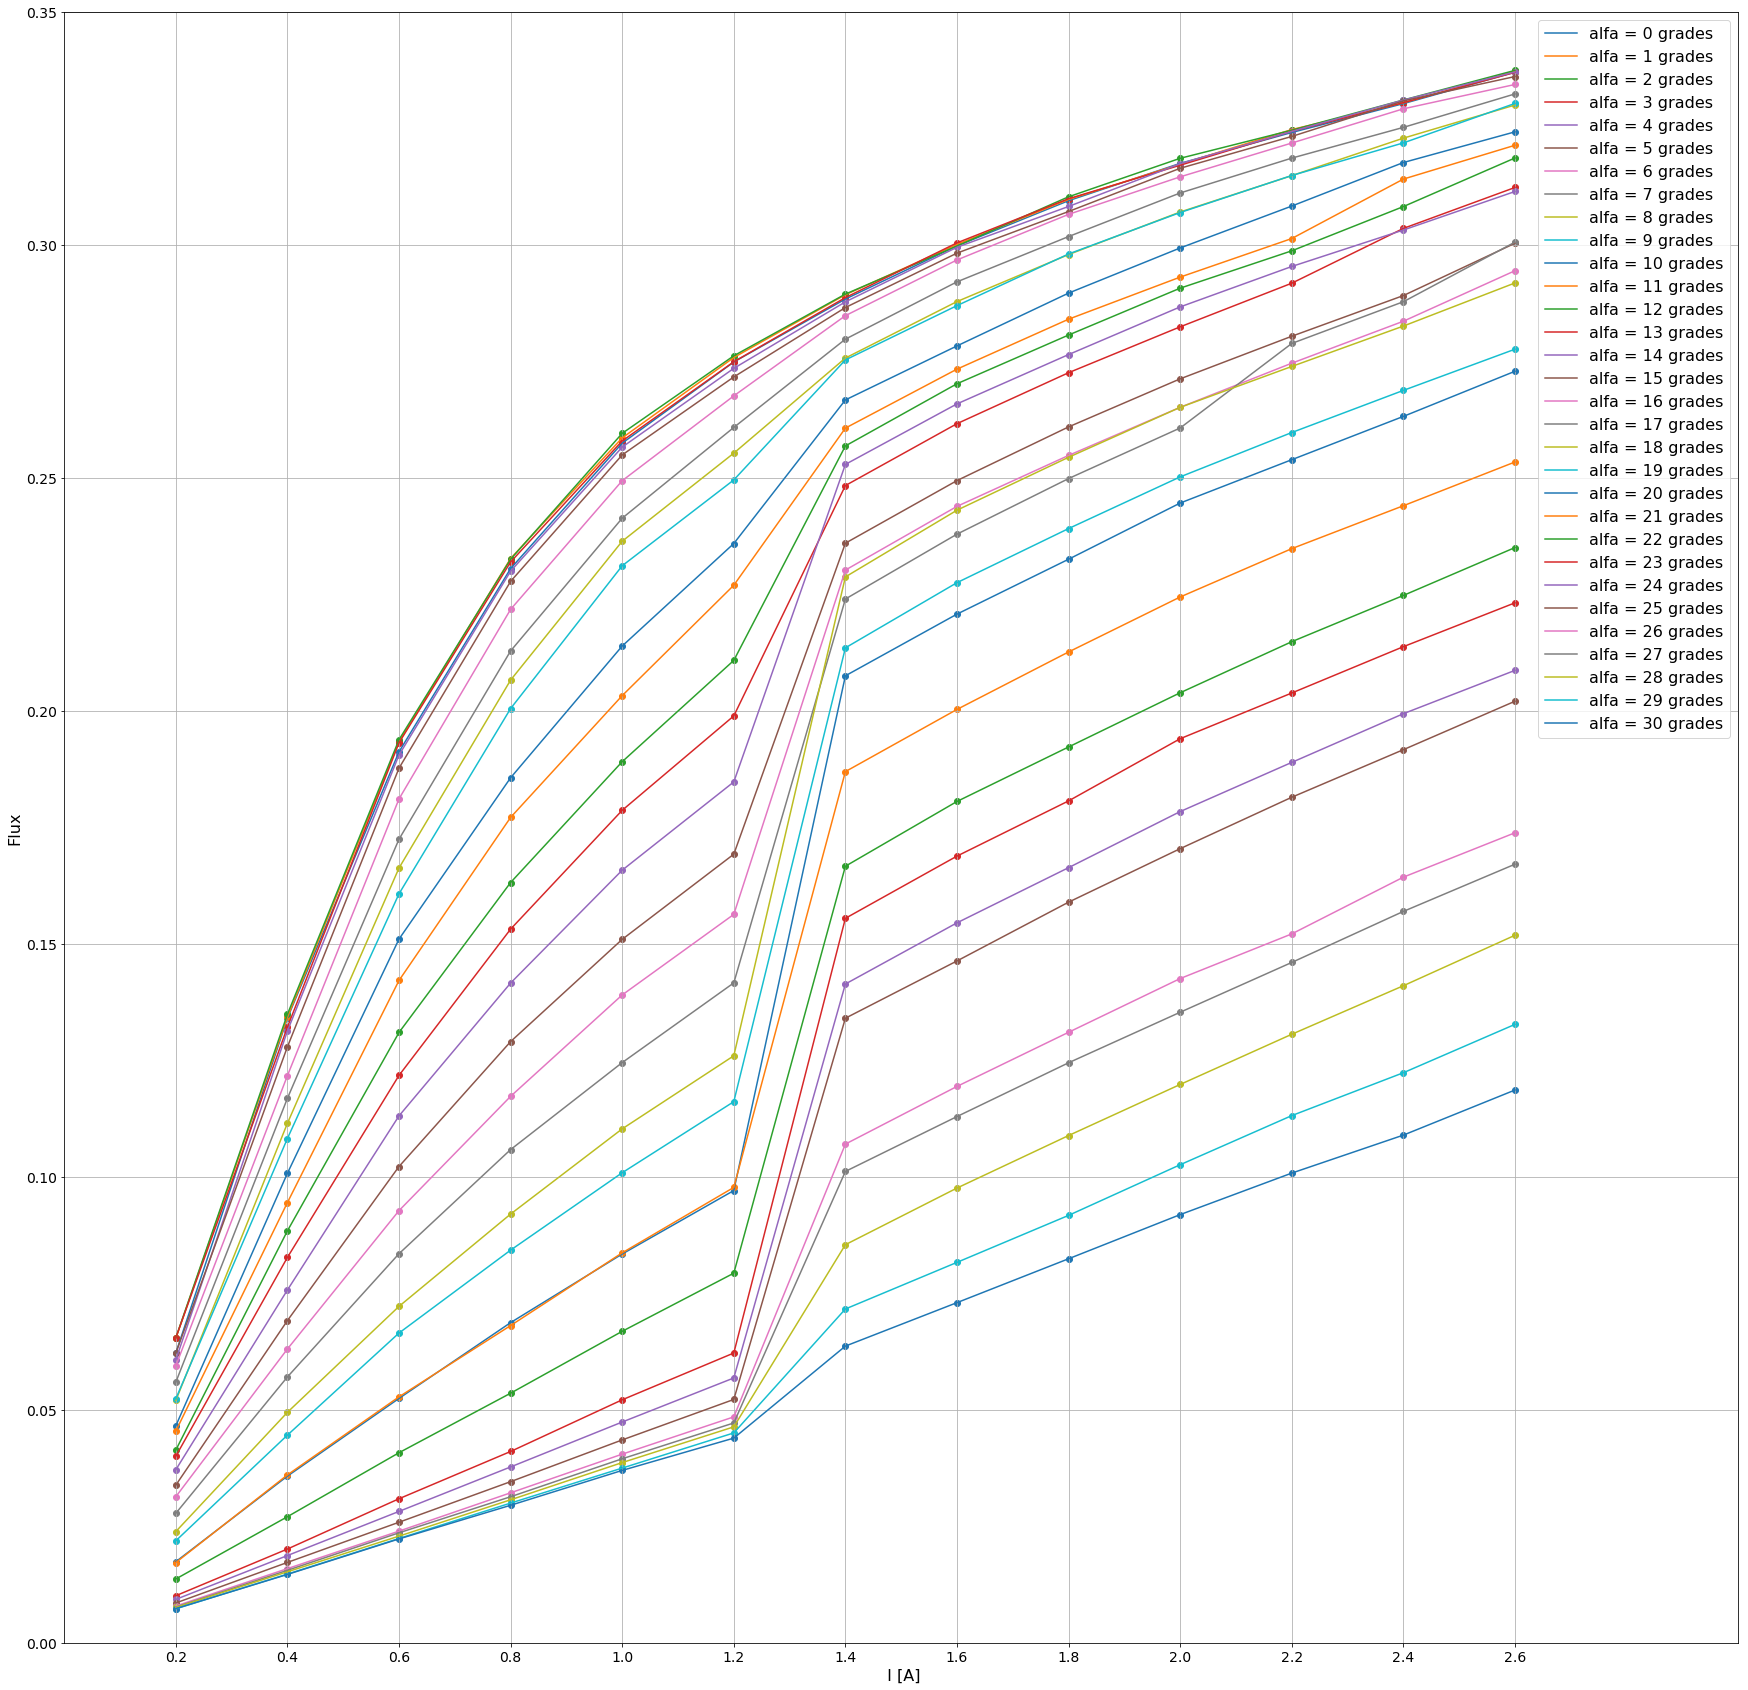

In [3]:
#

from subprocess import call
plt.clf()
plt.rcParams["figure.figsize"] = [30,30]
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14

flux = np.copy(Flux)

for idx in alfa:
    df =flux[idx, :]    
    plt.plot(I_currents, df, label='alfa = %d grades' %(idx))
    plt.ylim([0,0.35])
    plt.xlim([0, 3])
    plt.xticks(I_currents)
    plt.xlabel(xLabel, fontsize = 16)
    plt.ylabel(yLabel, fontsize = 16)
    plt.legend(loc='best', fontsize = 16)
    plt.scatter(I_currents,df)
plt.grid()
plt.savefig('SRM_george_output/SRM_Original_curves.png', dpi = 200)
plt.show()

# Use PCA to reduce the number of Ox points (curents)

- observed variable: flux at a specific curent

- sample: given an angle, measure flux value for different currents; we are oblivious of the angle under which the measurement was made; this descripition indicates only how all the samples were collected

- X.shape: (angles, currents)

- what we want: determine curents with highest variance (this what PCA does) across all grades



# Plot reconstruction error of PCA as a function of different number of components

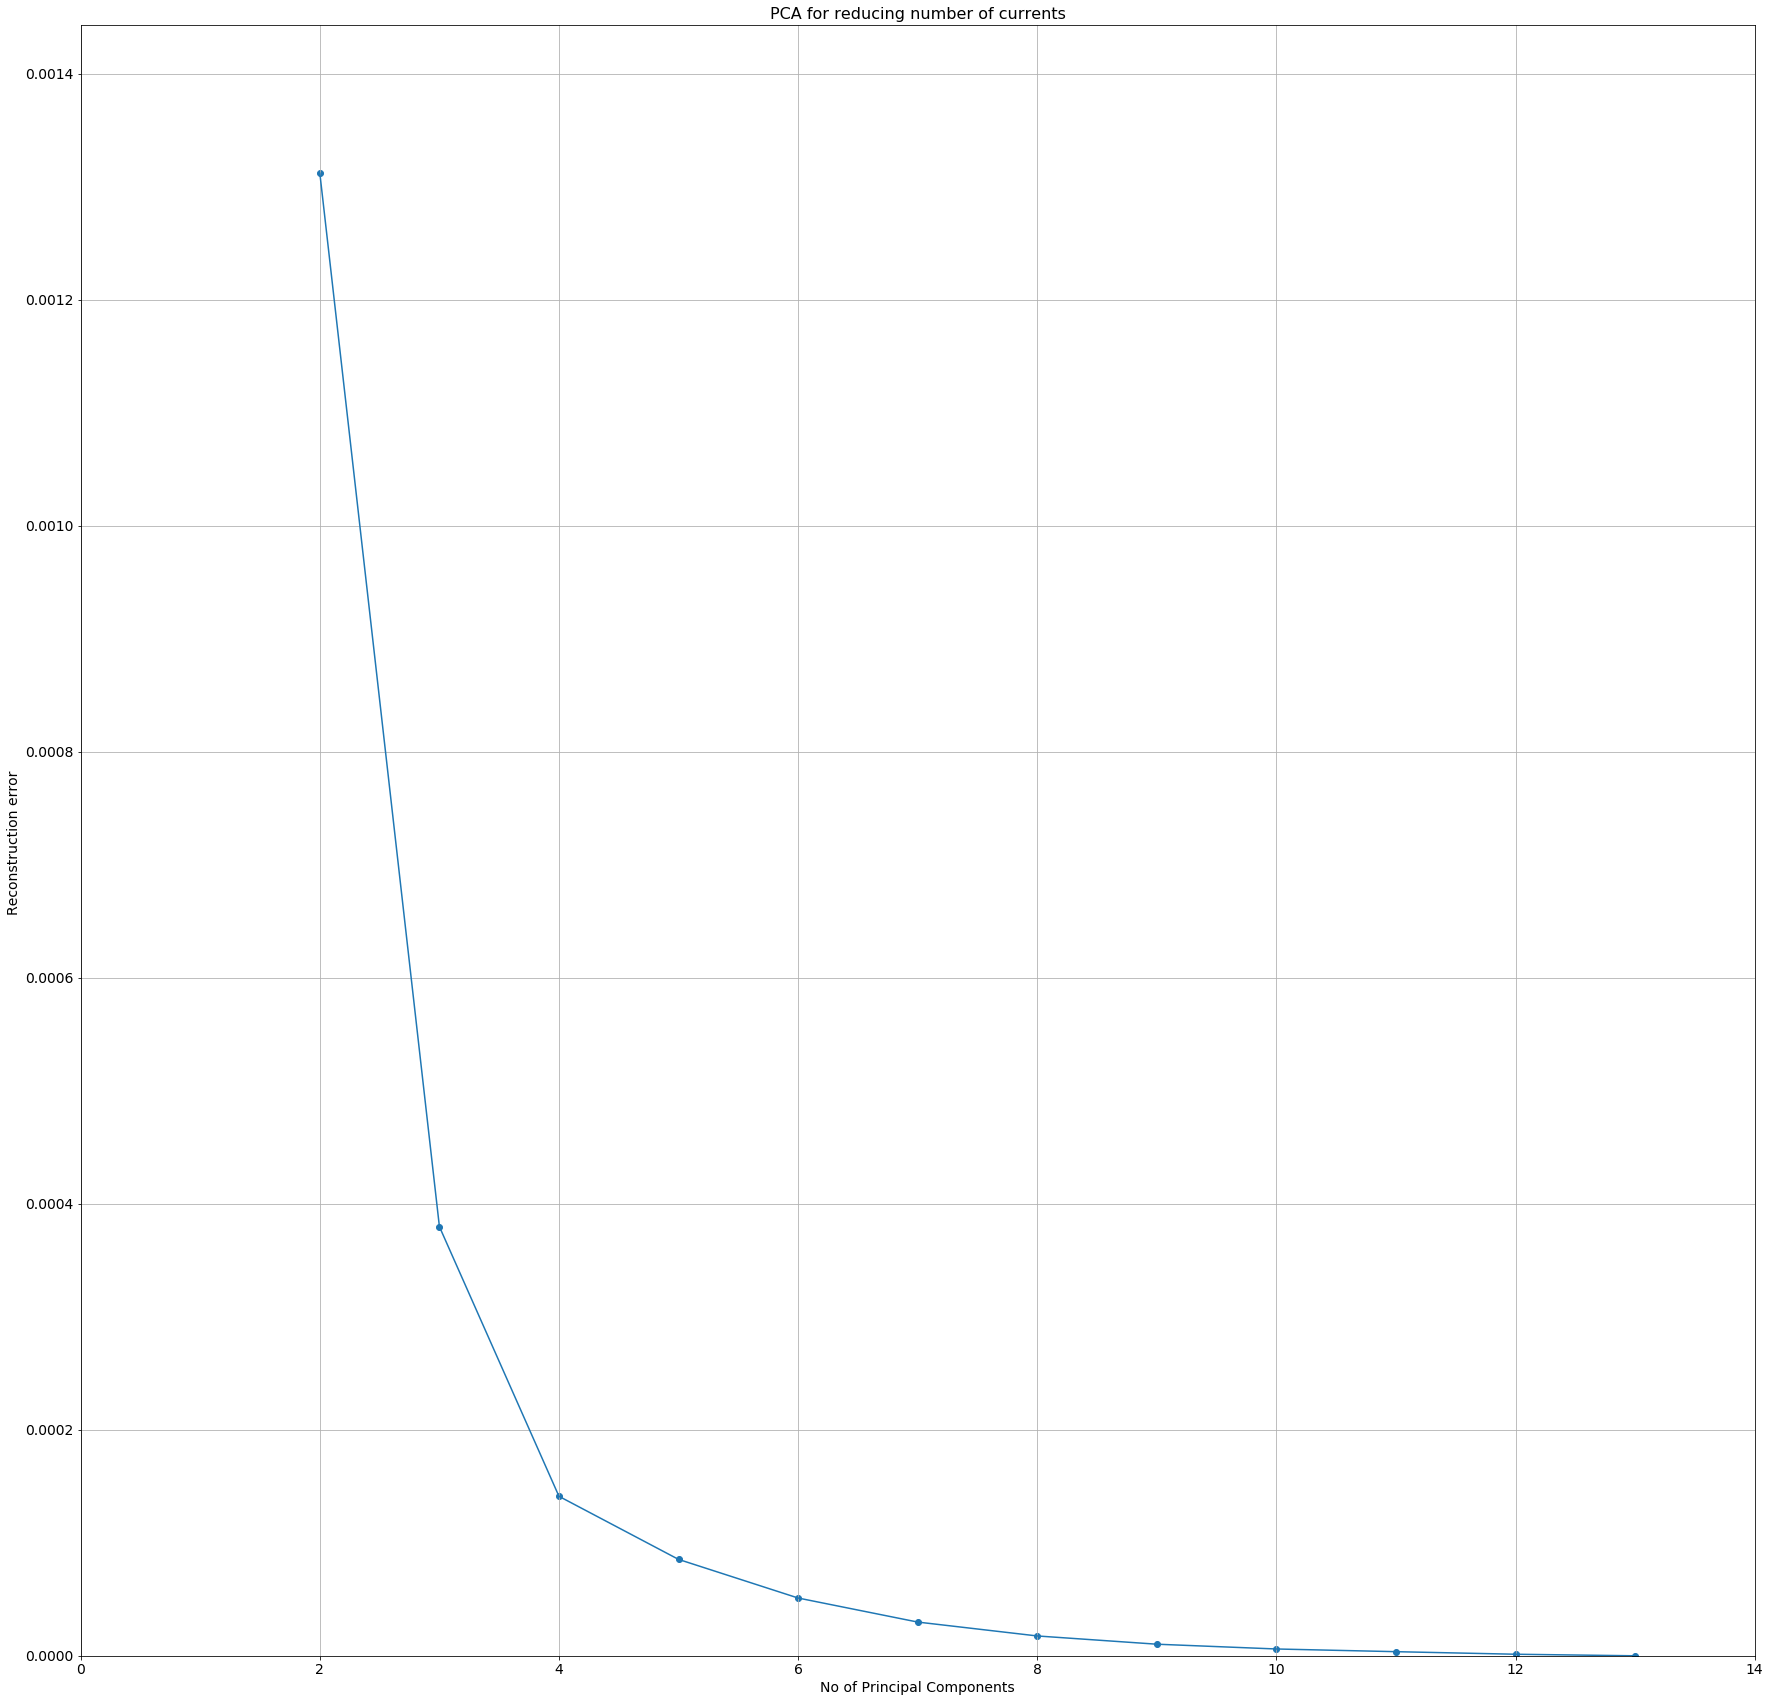

In [4]:
#
import numpy as np
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn import preprocessing

#preprocess the data
X = np.copy(Flux)
scaler = preprocessing.StandardScaler()
df_flux_scaled = scaler.fit_transform(X)

curve_indices = list(range(31))    
no_of_comps = range(2, 14)

errors = []
for comp in no_of_comps:
    pca_reduce_points = PCA(n_components=comp)
    flux_reduced = pca_reduce_points.fit_transform(df_flux_scaled)
    projected  = pca_reduce_points.inverse_transform(flux_reduced)
    projected_unscaled = scaler.inverse_transform(projected)
    errors.append(np.sum((projected_unscaled - flux) ** 2))

plt.figure()
plt.xlabel('No of Principal Components', fontsize = 14)
plt.ylabel('Reconstruction error ', fontsize = 14)
plt.xlim([0,14])
plt.ylim([0.1*min(errors), 1.1*max(errors)])
plt.locator_params(axis='x', nbins=len(no_of_comps))
plt.scatter(no_of_comps, errors)
plt.plot(no_of_comps, errors)
plt.grid()
plt.title('PCA for reducing number of currents', fontsize=16)
plt.savefig('SRM_george_output/errors_#PCS_reducing_#curents.png', dpi = 200)
plt.show()


# Find currents with highest variance and choose top n
- Alegem sa zicem 6. tu stii din plotul de mai sus ca 6 curenti iti dau eroare de reconstructie suficienta
- Am avut nevoie de PCA ca sa imi aleg n, avand o imagine despre cat o sa pierd

In [5]:
from sklearn.linear_model import Ridge
from pandas import DataFrame as df

X = np.copy(Flux)
variance = np.var(X, axis=0)
currents_variance = sorted(zip(I_currents, variance), key=lambda e : e[1], reverse=True)

def get_top_currents(currents_no):
    top_currents = sorted([e[0] for e in currents_variance[:currents_no]])
    return top_currents

top_n = range(2, len(I_currents))

for n in top_n:
    top_n_curents = get_top_currents(n)
    print('top %2d currents' % n, top_n_curents)

top  2 currents [1.0, 1.2]
top  3 currents [0.8, 1.0, 1.2]
top  4 currents [0.8, 1.0, 1.2, 1.6]
top  5 currents [0.8, 1.0, 1.2, 1.4, 1.6]
top  6 currents [0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
top  7 currents [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
top  8 currents [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2]
top  9 currents [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]
top 10 currents [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
top 11 currents [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
top 12 currents [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]


## We measure the flux value in key top n curents and then use cubic spline interpolation to predict flux across all curents
- plot Interpolation error as a function of the number of points used as basis per each curve
- we expect to get the same shape like in PCA reconstruction (first plot)

(31, 13)


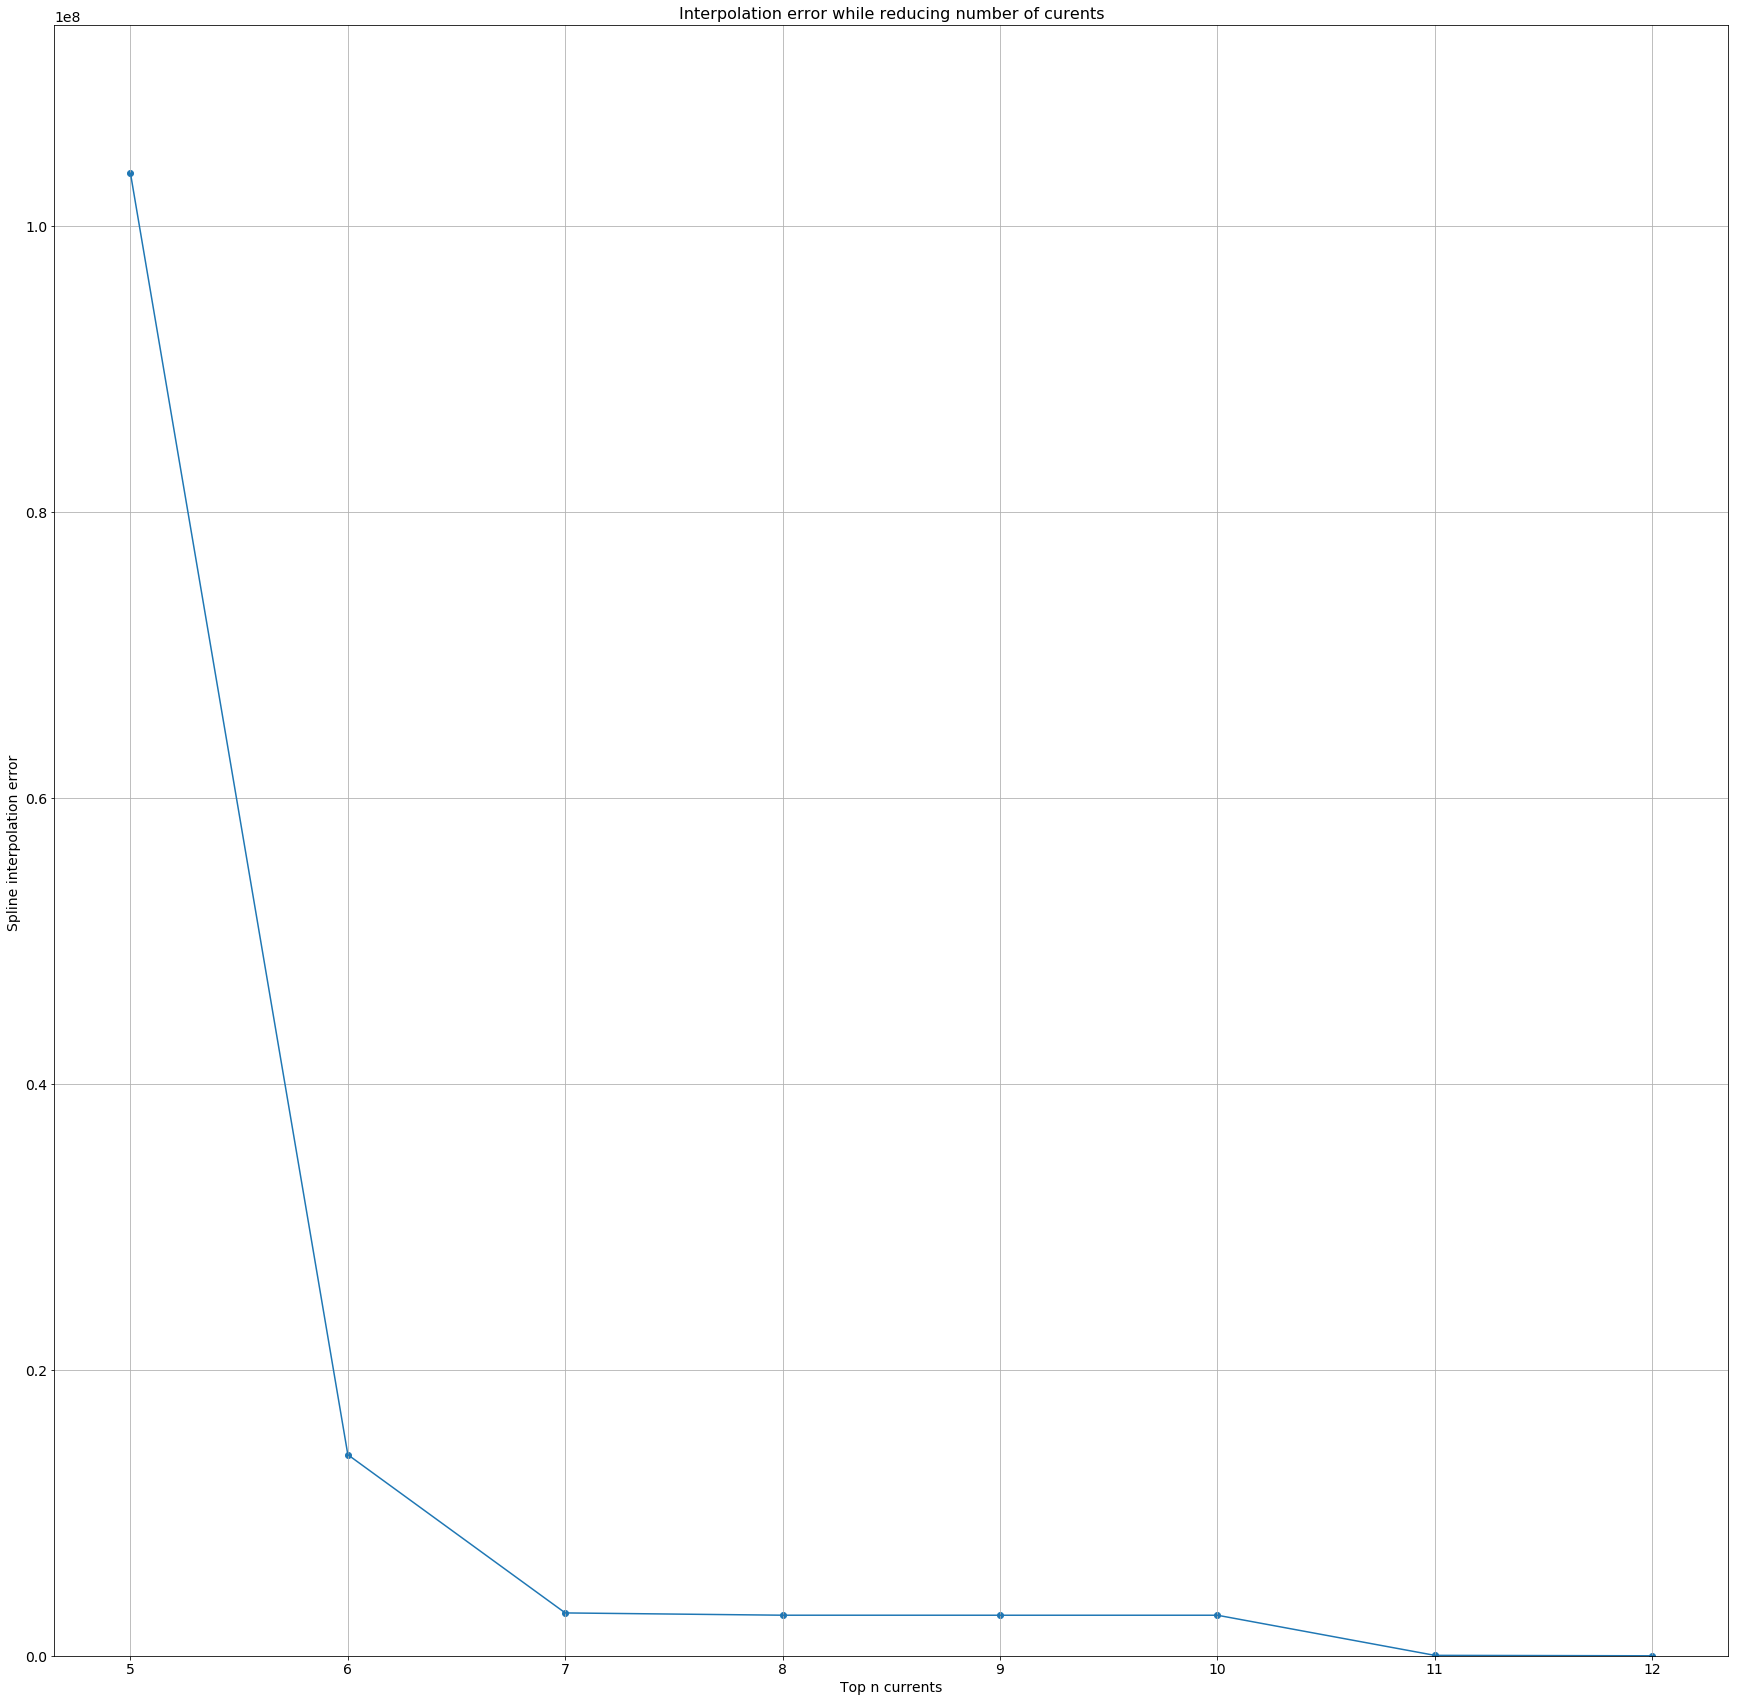

In [7]:
#cubic spline interpolation

from scipy.interpolate import interp1d
from scipy import interpolate
import itertools
import sys
from pandas import DataFrame as df

X = np.copy(Flux)
print(X.shape)

def sum_squared_error(gr, pred):
    gr = np.array(gr)
    pred = np.array(pred)
    return (10 ** 6) * (1 / gr.shape[0]) * sum((gr - pred) ** 2)

def get_index(vec, e):
    for i in range(len(vec)):
        if e == vec[i]:
            return i
    assert(False)

top_n = range(5, len(I_currents))
errors = []
for n in top_n:
    top_n_curents = get_top_currents(n)
    top_n_curents_indices = [get_index(I_currents, c) for c in top_n_curents]
    error = 0
    for curve in range(X.shape[0]):
        # baseline = y values obtained when interpolating with all ground truth points
        x = I_currents 
        baseline = X[curve, :] 

        # interpolate with top_n_currents as basis 
        x_ = top_n_curents
        y_ = X[curve, top_n_curents_indices]
        tck_ = interpolate.splrep(x_, y_, s=0)
        y = interpolate.splev(x, tck_) 
        
        # error -- difference between baseline interp curve and current one
        error += sum_squared_error(baseline, y)
    errors.append(error)
            
plt.xlabel('Top n currents', fontsize = 14)
plt.ylabel('Spline interpolation error ', fontsize = 14)
plt.ylim([0.1*min(errors), 1.1*max(errors)])
plt.locator_params(axis='x', nbins=len(top_n))
plt.scatter(top_n, errors)
plt.plot(top_n, errors)
plt.grid()
plt.title('Interpolation error while reducing number of curents', fontsize=16)
plt.savefig('SRM_george_output/errors_Spline_reducing_#curents.png', dpi = 200)
plt.show()


# TODO: inca nu am ajuns aici: PCA for reducing the number of curves - alfa


In [ ]:
#
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn import preprocessing
from pandas import DataFrame as df


#preprocess the data
flux = Flux.T
scaler = preprocessing.StandardScaler()
df_flux_scaled = scaler.fit_transform(flux)
weights  = []

no_of_comps = [13]

#table - average weights of PCs  
avg_weights_headers = ['Components'] + ['Alfa %d' % iq for iq in alfa]
avg_weights_rows = []

for comp in no_of_comps: #for each component
    pca_reduce_curves = PCA(n_components=comp)
    flux_reduced = pca_reduce_curves.fit_transform(df_flux_scaled)
    projected  = pca_reduce_curves.inverse_transform(flux_reduced)
    projected_unscaled = scaler.inverse_transform(projected)

    
    # plot main components
    plt.clf()
    plt.rcParams["figure.figsize"] = [12,8]
    plt.rcParams['xtick.labelsize']=12
    plt.rcParams['ytick.labelsize']=12
    
    components = pca_reduce_curves.components_
    components = scaler.inverse_transform(components)
        
    for idx in range(components.shape[0]):
        plt.plot(I_currents, components[idx, :], label='Principal Component %d'%idx)
        plt.xlabel(xLabel,fontsize=14)
        plt.ylabel(yLabel,fontsize=14)
        plt.legend(fontsize=12)  
        plt.ylim([0,0.35])
        plt.xlim([0, 2.65])
        plt.xticks(I_currents)
         
#     avg_weights = np.mean(abs(pca_reduce_curves.components_), axis=0)
#     weights.append(avg_weights.tolist())
#     avg_Iqs_weights_rows.append([comp] + avg_weights.tolist())
   
    
    plt.grid()
    plt.savefig('SRM_TOP{}PrincipalComponents.png'.format(comp), dpi = 200)  
    plt.show() 
        
# print PC meaning   
# print ("Meaning of the %d components(Weights for each IQ curve)"  %comp)
# table_PC = plotTable(headers=headers_meaning, rows=rows_meaning, column_width=True, precision=5) 
# print(table_PC)

# Interpret PCs for reducing the number of curves - Ridge Regression

In [ ]:
#
from sklearn.linear_model import Ridge
from pandas import DataFrame as df

X = Flux.T
y = alfa

model = Ridge(fit_intercept=True, normalize=True)
model.fit(X, y)

# best case 1, worst case -1, random prediction: 0
print('Regression train score: %.2f\n' % model.score(X, y))

components = pca_reduce_curves.components_
components = scaler.inverse_transform(components)

result = model.predict(components)
print('Predicted alfa: ')
for i, pred in enumerate(result):
    print('PCA_comp %d <=> alfa= %d grades' % (i, round(pred)))


#find upper and lower Iq curve
def border_curves(curve, interval):
    left = max([i for i in interval if i < curve])
    right = min([i for i in interval if i > curve])

    ## return index of left/right
    return interval.index(left), interval.index(right)


plt.clf()
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

top = 0
xAxis = list(I_currents))

#data for csv
ridge_for_csv = [[] for i in range(len(result))]


for comp in components:    
    pred_iq = model.predict(comp.reshape(1, -1))
    left, right = border_curves(pred_iq, alfa)
    plt.title('Principal component : %d' % (top+1),fontsize=18)
    plt.plot(I_currents, flux[:, left], label='Iq = %d A' % alfa[left])
    plt.plot(
        I_currents,
        components[top],
        color='black',
        label='Iq predicted for comp no %d = %d A' % (top + 1, pred_iq))
    plt.plot(I_currents, flux[:, right], label='Iq = %d A' % alfa[right])
    plt.legend(fontsize=14)
    plt.xlabel(xLabel, fontsize = 14)
    plt.ylabel(yLabel, fontsize = 14)
    plt.xticks(list(range(0, 240, 20)))
    plt.xlim(0, 220)
    plt.grid()
    plt.savefig('SRM_PCA_comp{}_Ridge.png'.format(top+1), dpi = 220)
    plt.show()
    
    # prepare data for csv
    
#     ridge_for_csv[top].append(round(pred_iq[0]))
#     ridge_for_csv[top].append(iqs[left])
#     ridge_for_csv[top].append(iqs[right])
    
#     top += 1

# save to csv
# df_ridge_to_csv_curves = df(data = ridge_for_csv)
# df_ridge_to_csv_curves.to_csv('SRM_RidgePcaCurves.csv')
# print(df_ridge_to_csv_curves)
# print(ridge_for_csv)
